In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sunxin/minico

1.13.2
2.2.4


Using TensorFlow backend.


In [2]:
import numpy as np
import scipy
from keras import models
from keras import layers
from keras.applications import inception_v3
from keras import backend as K
from keras.preprocessing.image import load_img, save_img, img_to_array
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
base_image_path = "test_deep_dream.jpg"
result_prefix = "deep_dream_result"

# These are the names of the layers
# for which we try to maximize activation,
# as well as their weight in the final loss
# we try to maximize.
# You can tweak these setting to obtain new visual effects.
settings = {
    'features': {
        'mixed2': 0.2,
        'mixed3': 0.5,
        'mixed4': 2.,
        'mixed5': 1.5,
    },
}

In [4]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = load_img(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [5]:
K.set_learning_phase(0)

# Build the InceptionV3 network with our placeholder.
# The model will be loaded with pre-trained ImageNet weights.
model = inception_v3.InceptionV3(weights='imagenet', include_top=False)
dream = model.input
print('Model loaded.')

Instructions for updating:
Colocations handled automatically by placer.
Model loaded.


In [6]:
# Get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Define the loss.
loss = K.variable(0.)
for layer_name in settings['features']:
    # Add the L2 norm of the features of a layer to the loss.
    if layer_name not in layer_dict:
        raise ValueError('Layer ' + layer_name + ' not found in model.')
    coeff = settings['features'][layer_name]
    x = layer_dict[layer_name].output
    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(x), 'float32'))
    loss = loss + coeff * K.sum(K.square(x[:, 2: -2, 2: -2, :])) / scaling

In [7]:
# Compute the gradients of the dream wrt the loss.
grads = K.gradients(loss, dream)[0]
# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())

# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)


def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

In [8]:
def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)

In [9]:
def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('..Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

In [10]:
# Playing with these hyperparameters will also allow you to achieve new effects
step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale
max_loss = 10.

img = preprocess_image(base_image_path)
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)

save_img(result_prefix + '.png', deprocess_image(np.copy(img)))

Processing image shape (258, 326)
..Loss value at 0 : 0.670993
..Loss value at 1 : 1.001118
..Loss value at 2 : 1.2985268
..Loss value at 3 : 1.5915651
..Loss value at 4 : 1.8841729
..Loss value at 5 : 2.1376612
..Loss value at 6 : 2.415501
..Loss value at 7 : 2.6696734
..Loss value at 8 : 2.9374306
..Loss value at 9 : 3.207608
..Loss value at 10 : 3.4853108
..Loss value at 11 : 3.758113
..Loss value at 12 : 4.0050817
..Loss value at 13 : 4.2754364
..Loss value at 14 : 4.4950294
..Loss value at 15 : 4.7628684
..Loss value at 16 : 4.9925537
..Loss value at 17 : 5.2343082
..Loss value at 18 : 5.4522057
..Loss value at 19 : 5.710664
Processing image shape (362, 457)


/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/scipy/ndimage/interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


..Loss value at 0 : 1.1198277
..Loss value at 1 : 1.761712
..Loss value at 2 : 2.3293757
..Loss value at 3 : 2.8331375
..Loss value at 4 : 3.3050628
..Loss value at 5 : 3.7465734
..Loss value at 6 : 4.1730967
..Loss value at 7 : 4.5674787
..Loss value at 8 : 4.9407735
..Loss value at 9 : 5.31402
..Loss value at 10 : 5.652837
..Loss value at 11 : 5.9892683
..Loss value at 12 : 6.318713
..Loss value at 13 : 6.6544075
..Loss value at 14 : 6.959302
..Loss value at 15 : 7.244253
..Loss value at 16 : 7.538124
..Loss value at 17 : 7.8137436
..Loss value at 18 : 8.091153
..Loss value at 19 : 8.373195
Processing image shape (507, 640)
..Loss value at 0 : 1.1527368
..Loss value at 1 : 1.8016484
..Loss value at 2 : 2.4113302
..Loss value at 3 : 3.002677
..Loss value at 4 : 3.6559248
..Loss value at 5 : 4.566645
..Loss value at 6 : 5.8331966
..Loss value at 7 : 7.9757357


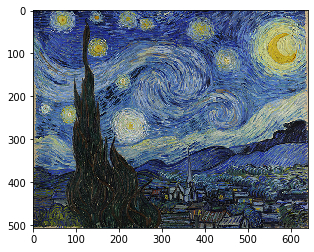

In [11]:
plt.imshow(load_img("test_deep_dream.jpg"))

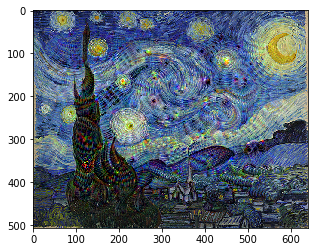

In [12]:
plt.imshow(load_img("deep_dream_result.png"))